# YOUR PROJECT TITLE

> **Note the following:** 
> 1. This is *not* meant to be an example of an actual **model analysis project**, just an example of how to structure such a project.
> 1. Remember the general advice on structuring and commenting your code from [lecture 5](https://numeconcopenhagen.netlify.com/lectures/Workflow_and_debugging).
> 1. Remember this [guide](https://www.markdownguide.org/basic-syntax/) on markdown and (a bit of) latex.
> 1. Turn on automatic numbering by clicking on the small icon on top of the table of contents in the left sidebar.
> 1. The `modelproject.py` file includes a function which could be used multiple times in this notebook.

Imports and set magics:

In [5]:
import numpy as np
from scipy import optimize
import sympy as sm
sm.init_printing(use_unicode=True) # for pretty printing
from IPython.display import display
import matplotlib.pyplot as plt # baseline modul

# autoreload modules when code is run
%load_ext autoreload
%autoreload 2

# local modules
import modelproject

# Model description

> **Note:** If you are not that friendly with markdown and latex you can refer to an external document with the model description instead.

We consider the **standard Solow-model** where:

1. 
* $K_t$ is capital
* $L_t$ is labor
* $A_t$ is technology
* $H_t$ is human capital
* $Y_t = F(K_t,H_t,A_tL_t)$ is GDP

**GDP** is defined as

$ Y_{t}=K_{t}^{\alpha}H_{t}^{\varphi}(A_{t}L_{t})^{1-\alpha-\varphi} $

The **real interest rate** consists of

$ r_{t}=\alpha\left(\dfrac{K_{t}}{A_{t}L_{t}}\right)^{\alpha-1}\left(\dfrac{H_{t}}{A_{t}L_{t}}\right)^{\varphi} $

The **real wage** consists of

$ r_{t}=\alpha\left(\dfrac{K_{t}}{A_{t}L_{t}}\right)^{\alpha}\left(\dfrac{H_{t}}{A_{t}L_{t}}\right)^{\varphi}A_t $


**Saving** is a constant fraction of GDP

$ S_t = (s_H+s_K)Y_t,\,s\in(0,1) $

such that **capital accumulates** according to

$ K_{t+1}=s_{K}Y_t+(1-\delta)K_{t}=sF(K_{t},H_{t},A_{t}L_{t})+(1-\delta)K_{t}, \delta \in (0,1) $

and **human capital accumulates** according to

$ H_{t+1} = s_{H}Y_t+(1-\delta)H_t $

**Labour and technology accoumulates** as

$ L_{t+1} = (1+n)L_t $

$ A_{t+1} = (1+g)A_t $

The **transition equations** then becomes

$ \tilde{k}_{t+1}= \frac{1}{(1+n)(1+g)}[s_K\tilde{k}_{t}^{\alpha}\tilde{h}_{t}^{\varphi}+(1-\delta)\tilde{k}_{t}] $

$ \tilde{h}_{t+1}= \frac{1}{(1+n)(1+g)}[s_H\tilde{k}_{t}^{\alpha}\tilde{h}_{t}^{\varphi}+(1-\delta)\tilde{h}_{t}] $


where $\tilde{k}_{t}= \dfrac{K_t}{A_tL_t}$

# Steady state

## Analytical solution

We can use **sympy** to find an analytical expression for the steady state, i.e. solve

$$ \tilde{k}^{\ast}= \frac{1}{(1+n)(1+g)}[s_K\tilde{k}^{\alpha\ast}\tilde{h}_{t}^{\varphi\ast}+(1-\delta)\tilde{k}^{\ast}] $$

and

$$ \tilde{h}^{\ast}= \frac{1}{(1+n)(1+g)}[s_K\tilde{k}^{\alpha\ast}\tilde{h}_{t}^{\varphi\ast}+(1-\delta)\tilde{h}^{\ast}] $$

First we define all **symbols**:

In [6]:
k = sm.symbols('k')
h = sm.symbols('h')
alpha = sm.symbols('alpha')
phi = sm.symbols('phi')
delta = sm.symbols('delta')
sh = sm.symbols('sh')
sk = sm.symbols('sk')
g = sm.symbols('g')
n = sm.symbols('n')

Then we define the **steady state equation**

In [7]:
ss1 = sm.Eq(k,(sk*k**alpha*h**phi+(1-delta)*k)/((1+n)*(1+g)))
ss2 = sm.Eq(h,(sh*k**alpha*h**phi+(1-delta)*h)/((1+n)*(1+g)))

and **solve** it

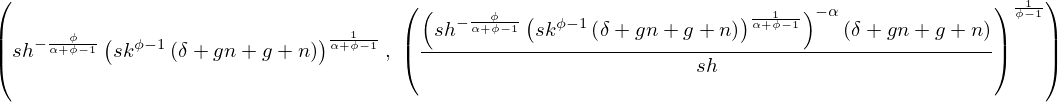

In [8]:
sss = sm.solve((ss1, ss2),(k,h))[0]
display(sss)

Which can be reduced to:

$$\tilde{k}^{\ast}=\left(\dfrac{s_K^{1-\varphi}s_H^{\varphi}}{n+g+\delta+ng}\right)^{\frac{1}{1-\alpha-\varphi}}$$

and

$$\tilde{h}^{\ast}=\left(\dfrac{s_K^{\alpha}s_H^{1-\alpha}}{n+g+\delta+ng}\right)^{\frac{1}{1-\alpha-\varphi}}$$

We turn the solution into a Python funciton

In [9]:
ss_func = sm.lambdify((sh,sk,g,n,alpha,phi,delta),sss)

## Numerical solution

We can re-write the equation for the steady state capital and human capital per capita as

\\[ 0 = \left(\dfrac{s_K^{1-\varphi}s_H^{\varphi}}{n+g+\delta+ng}\right)^{\frac{1}{1-\alpha-\varphi}} - \tilde{k}^{\ast} \\]

\\[ 0 = \left(\dfrac{s_K^{\alpha}s_H^{1-\alpha}}{n+g+\delta+ng}\right)^{\frac{1}{1-\alpha-\varphi}} - \tilde{h}^{\ast} \\]


whereby it clearly becomes a **root-finding problem**. Such a problem can be solved by a **bisection method**.

Define the model **parameters**:

In [63]:
sh = 0.1
sk = 0.2
g = 0.02
n = 0.01
alpha = 1/3
phi = 1/3
delta = 0.1

**Solve numerically** for the steady state:

In [125]:
def h_func(k,sh,sk,g,n,alpha,phi,delta,h):
    return 1/((1+n)*(1+g))*(sh*k**(alpha)*h**(phi)+(1-delta)*h)-h

def k_func(h,sh,sk,g,n,alpha,phi,delta,k):
    return 1/((1+n)*(1+g))*(sk*k**(alpha)*h**(phi)+(1-delta)*k)-k

obj1 = lambda x: [h_func(x[1],sh,sk,g,n,alpha,phi,delta,x[0]),k_func(x[0],sh,sk,g,n,alpha,phi,delta,x[1])]

sol= optimize.root(obj1,[1,1],method='broyden1')

sol.x

array([0.90609957, 1.81219305])

In [121]:
analSolution = ss_func(sh,sk,g,n,alpha,phi,delta)
nummiSolution = sol.x

print(f'Analytical solution is: k* {analSolution[0]:.3f}, h* {analSolution[1]:.3f}')
print(f'Numerical solution is: k* {nummiSolution[1]:.3f}, h* {nummiSolution[0]:.3f}')


Analytical solution is: k* 1.812, h* 0.906
Numerical solution is: k* 1.812, h* 0.906


# Further analysis

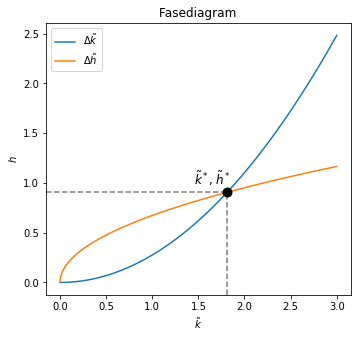

In [180]:
def solve_ss(sh,sk,g,n,alpha,phi,delta):

    # a. grids
    k_vec = np.linspace(1e-4,3,500)
    h_vec_DeltaK0 = np.empty(500)
    h_vec_DeltaH0  = np.empty(500)
    
    # b. solve for each m2 in grid
    for i,k in enumerate(k_vec):
        #Solve for delta_h=0
        
        # i. objective
        obj = lambda h: -h_func(k,sh,sk,g,n,alpha,phi,delta,h)

        # iii. optimizer
        result = optimize.root_scalar(obj,method='brentq',bracket=[1e-20,50])
        
        h_vec_DeltaH0[i] = result.root

       
        #Solve for delta_k=0
        # i. objective
        obj = lambda h: -k_func(h,sh,sk,g,n,alpha,phi,delta,k)

        # iii. optimizer
        result = optimize.root_scalar(obj,method='brentq',bracket=[1e-20,50])

        h_vec_DeltaK0[i] = result.root

    return k_vec,h_vec_DeltaK0, h_vec_DeltaH0

k_vec,h_vec_DeltaK0, h_vec_DeltaH0 = solve_ss(sh,sk,g,n,alpha,phi,delta)


#Create the plot
fig = plt.figure(figsize=(12,5))
ax = fig.add_subplot(1,2,1)
ax.plot(k_vec,h_vec_DeltaK0, label=r'$\Delta \tilde{k}$')
ax.plot(k_vec,h_vec_DeltaH0, label=r'$\Delta \tilde{h}$')
plt.scatter(sol.x[1],sol.x[0],color='black',s=80,zorder=2.5)
plt.axvline(sol.x[1],ymax=0.38,color='gray',linestyle='--')
plt.axhline(sol.x[0],xmax=0.6,color='gray',linestyle='--')
ax.text(1.45, 0.98, r'$\tilde{k}^*, \tilde{h}^*$', fontsize=12)
ax.set_xlabel(r'$\tilde{k}$')
ax.set_ylabel('$h$')
ax.legend()
ax.set_title('Fasediagram');

# Conclusion

ADD CONCISE CONCLUSION.